In [1]:
This notebook looks at printing a vertical profile in EFDC.


 


In [2]:

import pandas as pd
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# generally in EFDC our domain is bounded by land cells at the outer edges; drop these from viz
land_bounded_cells = 2  
def getcoordinates(ncdataset):
    x = ncdataset.variables['X'][:]
    y = ncdataset.variables['Y'][:]
    x = x[land_bounded_cells:-land_bounded_cells]
    y = y[land_bounded_cells:-land_bounded_cells]
    time = ncdataset.variables['Time'][:]
    return x, y, time

def getvariablevalues(ncdataset, variable):
    var0 = ncdataset.variables[variable][:]
    if (len(var0.shape)==1):
        return var0.data
    var1 = var0[0]
    if (len(var1.shape) == 2):
        var1 = var1[land_bounded_cells:-land_bounded_cells, land_bounded_cells:-land_bounded_cells]
    if (len(var1.shape) == 3):
        var1 = var1[:, land_bounded_cells:-land_bounded_cells, land_bounded_cells:-land_bounded_cells]   
    return var1

/Users/fearghalodonncha/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data_directory = "../../SampleModels/CobscookBayModel/"
fname = data_directory + "efdcout_20190102000000.nc"
ncdataset = nc.Dataset(fname)
x, y, time = getcoordinates(ncdataset)


<ipython-input-3-268344256d76>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = ncdataset.variables['X'][:]


## Current oversight is that water depth are not included in NetCDF files
Read these instead from DXDY.INP <br>
Clunky way of doing it but works for now


In [5]:
## Current oversight is that water depth are not included in the netcdf file
## We need to read from DXDY.INP file
dxdy = pd.read_csv(data_directory + "DXDY.INP", skiprows=4,
                   names = ["I", "J", "dx", "dy", "dpth", "elev", "zruff", "veg"], 
                   delim_whitespace = True)
## Create the 2D array based on I and J coordinates
## remember to account for fact we:
## 1) stripped two cells along the edges (-2)
## 2) Python is zero-based (-1)
depth = np.zeros([len(y), len(x)])
for il in range(0, len(dxdy)):
    c = dxdy["I"].iloc[il] - 2 - 1
    r = dxdy["J"].iloc[il] - 2 - 1
    depth[r, c] = dxdy['dpth'].iloc[il]

## Total depth and plot

<ipython-input-3-268344256d76>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  var0 = ncdataset.variables[variable][:]


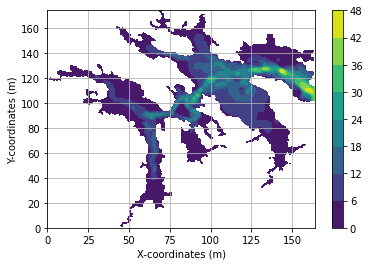

In [6]:
elev = getvariablevalues(ncdataset, 'Elevation')
water_depth = elev + depth
plt.contourf( water_depth)
plt.grid()
plt.xlabel('X-coordinates (m)')
plt.ylabel('Y-coordinates (m)')
plt.colorbar()


Text(0.5, 1.0, 'Vertical section through red line')

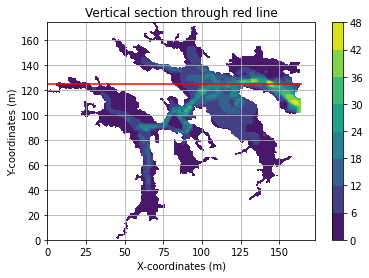

In [7]:
## Extract coords of location, depth, and temperature at a particular location
## For illustrative purpose, take point x == 140
pt = 125
plt.contourf( water_depth)
plt.grid()
plt.xlabel('X-coordinates (m)')
plt.ylabel('Y-coordinates (m)')
plt.colorbar()
plt.hlines(pt, xmin = 0, xmax=(water_depth.shape[1]), colors= 'r')
plt.title('Vertical section through red line')


In [8]:
loc = x[pt]
d_pt = water_depth[pt, :]
tracer = getvariablevalues(ncdataset, 'Tracer') ## We extract Tracer to illustrate
sigma_layers = getvariablevalues(ncdataset, 'Depth')  ## the number of layers and thickness of each

## We extract tracer values corresponding the the vertical line at the pt highlighted in figure above
trace_sect = tracer[:,pt,:] # note that tracer is 3D of size n_sigma_layers, X, Y


<ipython-input-3-268344256d76>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  var0 = ncdataset.variables[variable][:]


## Extract the x and y coordinates to plot vertical profile
The `tracer_sect` variable generated above is a 2D array of dimensions [nlayers, n_y_gridcells] <br>
We also need x and y coordinates to plot <br>
We extract y coord for each point in the horizontal and vertical <br>
i.e. create an array of size [nlayers, n_y_gridcells] where we specify position in the 
vertical water column (based on water depth and layer number) and the point in the horizontal (based on the x-coordinate)


In [9]:
d_pt_arr = np.zeros([len(sigma_layers), len(d_pt)]) # create empty array
for i in range(0, len(d_pt)):
    # for each grid cell, create the position at the different layers
    # note that water depth is positive so we flip
    # Also note that sigma layers is from 0 - 100 so we convert to 0 - 1
    d_pt_arr[:, i] = -d_pt[i]*(sigma_layers/100) 

x_plot = np.tile(np.arange(0,len(x)), (len(sigma_layers),1))


# Now plot the vertical profile

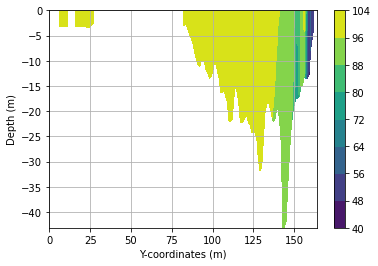

In [10]:
plt.contourf(x_plot, d_pt_arr,trace_sect)
plt.colorbar()
plt.xlabel('Y-coordinates (m)')
plt.ylabel('Depth (m)')
plt.grid()